# Testing H-MDS Implementation

# Python/Numpy Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
#plt.style.use('classic')
#plt.rcParams['figure.figsize'] = (6.5, 6.5)
#plt.rcParams['figure.facecolor'] = 'white'
#from jupyterthemes import jtplot
#jtplot.style()

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [46]:
def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

def poincare_dist(u, v, eps=1e-5):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)
u1 = np.array([0.5, 0.5])
v1 = np.array([0.3, 0.3])
poincare_dist(u1, v1, eps=0)

0.8569857606976118

In [177]:
def poincare_dist2(zi, zj):
    val = norm(zi - zj) / norm(1-zi*np.conj(zj))
    return 2* np.arctanh(val)
z1 = 0.5 + 0.5j
z2 = 0.3 + 0.3j
poincare_dist2(z1, z2)

0.8569857606976117

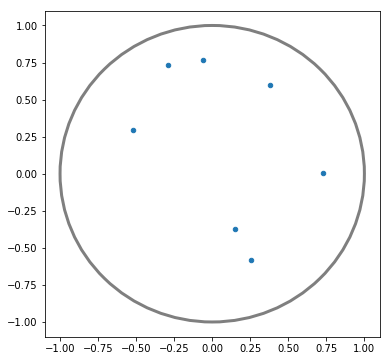

In [181]:
# generate a small set of random points in poincaré disk
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

# sample within unit sphere in R^2
n = 7
theta = np.random.uniform(0, 2*np.pi, n)
u = np.random.uniform(0, 0.7, n)
r = np.sqrt(u)
x = r * np.cos(theta)
y = r * np.sin(theta)
init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
ax.scatter(x, y, s=20, alpha=1);

In [182]:
delta1 = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        delta1[i][j] = poincare_dist(init_data[i], init_data[j])
delta1

array([[0.        , 2.12867232, 3.167325  , 2.5806899 , 1.78017608,
        2.15012335, 2.78879069],
       [2.12867232, 0.        , 3.28133422, 1.8185118 , 1.10632533,
        2.86138972, 3.49699742],
       [3.167325  , 3.28133422, 0.        , 2.2906886 , 3.61837977,
        1.90560041, 2.30597086],
       [2.5806899 , 1.8185118 , 2.2906886 , 0.        , 2.47115754,
        2.43831966, 3.03533665],
       [1.78017608, 1.10632533, 3.61837977, 2.47115754, 0.        ,
        2.99698601, 3.63982759],
       [2.15012335, 2.86138972, 1.90560041, 2.43831966, 2.99698601,
        0.        , 0.64463812],
       [2.78879069, 3.49699742, 2.30597086, 3.03533665, 3.63982759,
        0.64463812, 0.        ]])

In [50]:
init_complex = init_data[:,0] + 1j * init_data[:,1]
init_complex
init_complex.shape

array([-0.41456836-0.5243367j ,  0.42123099-0.47386274j,
        0.11504086-0.24161051j, -0.3304627 +0.47914936j,
        0.13995891-0.62728662j,  0.38856775-0.12835373j,
        0.77618171-0.25234063j])

(7,)

In [53]:
delta2 = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        delta2[i][j] = poincare_dist2(init_complex[i], init_complex[j])
norm(delta1 - delta2)

0.0001591457309295678

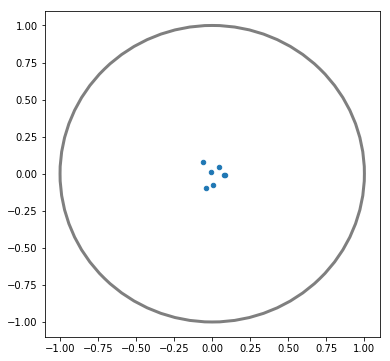

In [183]:
def init_z(n, dim=2, low=-0.1, high=0.1):
    random_config = np.random.uniform(low, high, size=(n, dim))
    return random_config

# plot initial random configuration
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

init_config = init_z(7)
x = init_config[:,0]
y = init_config[:,1]
ax.scatter(x, y, s=20, alpha=1);

In [55]:
eps = 1e-5
def partial_d(theta, x):
    alpha = 1 - norm(theta)**2
    beta = 1 - norm(x)**2
    gamma = 1 + 2/(alpha*beta + eps) * norm(theta-x)**2
    lhs = 4 / (beta*np.sqrt(gamma**2 - 1) + eps)
    rhs = 1/(alpha**2 + eps) * (norm(x)**2 - 2*np.inner(theta,x) + 1) * theta - x/(alpha + eps)
    return lhs*rhs

def proj(theta):
    if norm(theta) >= 1:
        theta = theta/norm(theta) - eps
    return theta

In [107]:
def loss_fn(embed_config, dissimilarities, n, alpha=1):
    loss = 0
    for i in range(n):
        for j in range(i+1, n):
            #print(poincare_dist(embed_config[i], embed_config[j]))
            zi_error = (poincare_dist(embed_config[i], embed_config[j]) - alpha*dissimilarities[i][j])**2
            loss += zi_error
    return loss
loss_fn(init_config, dissimilarity, n=len(init_config))

def compute_gradients(Z, dissimilarities, n, alpha=1):
    gradients = np.zeros((n, 2))
    for i in range(n):
        grad_zi = 0
        for j in range(i+1, n):
            dd_loss = 2*poincare_dist(Z[i], Z[j]) - 2*alpha*dissimilarities[i][j]
            dd_dist = partial_d(Z[i], Z[j])
            grad_zi += dd_loss * dd_dist
        gradients[i] = grad_zi
    return gradients
compute_gradients(init_config, dissimilarity, len(init_config))

def conjugate(z):
    z_bar = np.array([z[0], -z[1]])
    return z_bar
conjugate([1, 2])

130.25672834822674

array([[ 28.18765633, -17.60082631],
       [ 31.1043808 ,  -0.2697067 ],
       [-22.24843306, -22.83768339],
       [  0.31689074, -14.02874819],
       [ 15.32659284,  -6.56164175],
       [ -2.9354551 ,  -2.43803004],
       [  0.        ,   0.        ]])

array([ 1, -2])

We only need to compute the derivative of q(r) evaluated at 0, so here we just plug 0 into q'(r) <br>
<br>
$$
\begin{aligned} q^{\prime}(0) &=\frac{d}{d r} q(0)\\ &=\left(\operatorname{Re} \mathbf{M}^{\prime}(-r \mathbf{g}, \mathbf{z})\right)^{T} \operatorname{Re} \nabla E(\mathbf{M}(-r \mathbf{g}, \mathbf{z}), \boldsymbol{\Delta}, \mathbf{W}, \mathbf{I}) \\ &+\left(\operatorname{Im} \mathbf{M}^{\prime}(-r \mathbf{g}, \mathbf{z})\right)^{T} \operatorname{Im} \nabla E(\mathbf{M}(-r \mathbf{g}, \mathbf{z}), \boldsymbol{\Delta}, \mathbf{W}, \mathbf{I}) \end{aligned}
$$ <br>
with step size = 0 we also have: <br>
$$
M_{j}(0)=z_j
$$<br>
$$
M_{j}^{\prime}(0)=g_{j} (\left|z_{j}\right|^{2}-1)
$$

In [176]:
eps=1e-5
def q(r, Z, g, dissimilarities, n):
    M_r = np.zeros((n, 2))
    for j in range(n):
        M_r[j] = (-r*g[j] + Z[j]) / (-r*g[j] * conjugate(Z[j]) + 1)
        #print(M_r[j])
    return loss_fn(M_r, dissimilarities, n)
init_grad = compute_gradients(init_config, delta1, len(init_config))
#init_grad
smax = 1
rmax = 1/(norm(init_grad, axis=1).max()+eps) * np.tanh(smax/2)
rmax
q(rmax, init_config, init_grad, delta1, n)
#loss_fn(init_config, delta1, n=len(init_config))

0.05879914737737489

nan

In [168]:
def line_search(Z, dissimilarities, n, r0, rmax):
    Z_norm = norm(Z, axis=1)**2
    g = compute_gradients(Z, dissimilarity, n)
    M_prime = g*Z_norm.reshape(-1,1)
    qprime_0 = np.dot(M_prime[:,0].T, g[:,0]) + np.dot(M_prime[:,1].T, g[:,1])
    p=0.5
    roof_fn = lambda r: q(0, Z, g, dissimilarities, n) + p*qprime_0*r
    r = r0
    rmin = 1e-5
    while rmin < r < rmax and q(r, Z, g, dissimilarities, n) < roof_fn(r):
        print('Loop 1: ', r)
        print(q(r, Z, g, dissimilarities, n) < roof_fn(r))
        r = 2*r
    print(q(r, Z, g, dissimilarities, n) < roof_fn(r))
    while r > rmax or q(r, Z, g, dissimilarities, n) > roof_fn(r):
        print('Loop 2: ', r)
        r = r/2
    print(rmin < r < rmax)
    print(q(r, Z, g, dissimilarities, n) <= roof_fn(r))
    print(q(r, Z, g, dissimilarities, n))
    print(roof_fn(r))
    return r
line_search(init_config, delta1, len(init_config), 0.01, rmax)

False
True
False
nan
45.800194292642


0.01

In [184]:
def descent_method(init, dissimilarities, n_components=2, max_iter = 100, verbose=0, alpha=1,
                   weights=None, indicators=None):
    #error_tol =
    #min_grad = 
    #min_step = 
    Z = init
    n = len(Z)
    smax = 1
    for i in range(2):
        current_loss = loss_fn(Z, dissimilarities, n)
        g = compute_gradients(Z, dissimilarities, n)
        rmax = 1/(norm(g, axis=1).max()+eps) * np.tanh(smax/2)
        r = line_search(Z, dissimilarities, n, 0.001, rmax)
        for i in range(n):
            zi_prime = (-r*g[i] + Z[i]) / (-r*g[i] * conjugate(Z[i]) + 1)
            Z[i] = zi_prime
    return Z
output = descent_method(init_config, delta1)

Loop 1:  0.001
True
Loop 1:  0.002
True
Loop 1:  0.004
True
Loop 1:  0.008
True
True
Loop 2:  0.016
True
True
85.69792746045901
120.63996596221355
Loop 1:  0.001
True
Loop 1:  0.002
True
Loop 1:  0.004
True
Loop 1:  0.008
True
True
Loop 2:  0.016
True
True
46.8753144563826
82.3368680745245


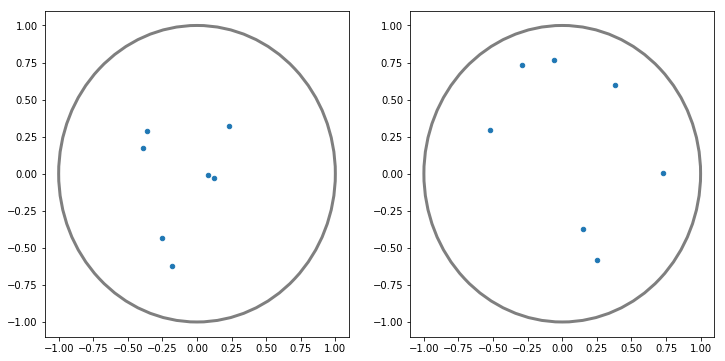

In [192]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

x = output[:,0]
y = output[:,1]
ax.scatter(x, y, s=20, alpha=1)

ax2 = fig.add_subplot(122)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax2.add_patch(circ)

x = init_data[:,0]
y = init_data[:,1]
ax2.scatter(x, y, s=20, alpha=1);

In [ ]:
class HyperMDS():
    
    def __init__(self, n_components=2, max_iter=100, verbose=0, eps=1e-3, n_jobs=None,
                 random_state=None, dissimilarity="euclidean"):
        self.n_components = n_components
        self.dissimilarity = dissimilarity
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.n_jobs = n_jobs
        self.random_state = random_state
    
    def fit(self, X, init=None):
        """
        Uses gradient descent to find the embedding configuration in the Poincaré disk
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        self.fit_transform(X, init=init)
        return self
    
    def fit_transform(self, X, init=None):
        """
        Fit the embedding from X, and return the embedding coordinates
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """